# Early stopping

In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_05_anneal")' FastaiNotebook_05_anneal

Installing packages:
	.package(path: "/home/jupyter/git/fastai_dev/swift/FastaiNotebook_05_anneal")
		FastaiNotebook_05_anneal
With SwiftPM flags: []
Working in: /tmp/tmppqafhh_n/swift-install
/home/jupyter/swift/usr/bin/swift: /home/jupyter/anaconda3/lib/libuuid.so.1: no version information available (required by /home/jupyter/swift/usr/bin/swift)
/home/jupyter/swift/usr/bin/swift: /home/jupyter/anaconda3/lib/libuuid.so.1: no version information available (required by /home/jupyter/swift/usr/bin/swift)
/home/jupyter/swift/usr/bin/swift: /home/jupyter/anaconda3/lib/libuuid.so.1: no version information available (required by /home/jupyter/swift/usr/bin/swift)
/home/jupyter/swift/usr/bin/swift: /home/jupyter/anaconda3/lib/libuuid.so.1: no version information available (required by /home/jupyter/swift/usr/bin/swift)
/home/jupyter/swift/usr/bin/swift: /home/jupyter/anaconda3/lib/libuuid.so.1: no version information available (required by /home/jupyter/swift/usr/bin/swift)
/home/jupyter/swi

In [ ]:
//export
import Path
import TensorFlow
import Python

In [ ]:
import FastaiNotebook_05_anneal

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## Load data

In [ ]:
let data = mnistDataBunch(flat: true)

In [ ]:
let (n,m) = (60000,784)
let c = 10
let nHid = 50

In [ ]:
func optFunc(_ model: BasicModel) -> SGD<BasicModel> {return SGD(for: model, learningRate: 1e-2)}

In [ ]:
func modelInit() -> BasicModel {return BasicModel(nIn: m, nHid: nHid, nOut: c)}

In [ ]:
let learner = Learner(data: data, lossFunc: crossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeRecorder()

Check the previous callbacks load.

In [ ]:
learner.delegates = [learner.makeTrainEvalDelegate(), learner.makeShowProgress(),
                     learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std),
                     learner.makeAvgMetric(metrics: [accuracy]), recorder]

In [ ]:
learner.fit(2)

Epoch 0: [0.3043451, 0.9155]                                                   
Epoch 1: [0.2507822, 0.9277]                                                   


Make an extension to quickly load them. 

In [ ]:
// export
//TODO: when recorder can be accessed as a property, remove it from the return
extension Learner where Opt.Scalar: PythonConvertible {
    public func makeDefaultDelegates(metrics: [(Output, Label) -> TF] = []) -> Recorder {
        let recorder = makeRecorder()
        delegates = [makeTrainEvalDelegate(), makeShowProgress(), recorder]
        if !metrics.isEmpty { delegates.append(makeAvgMetric(metrics: metrics)) }
        return recorder
    }
}

## Control Flow test

In [ ]:
extension Learner {
    public class TestControlFlow: Delegate {
        public override var order: Int { return 3 }
        
        var skipAfter,stopAfter: Int
        public init(skipAfter:Int, stopAfter: Int){  (self.skipAfter,self.stopAfter) = (skipAfter,stopAfter) }
        
        public override func batchWillStart(learner: Learner) throws {
            print("batchWillStart")
            if learner.currentIter >= stopAfter {
                throw LearnerAction.stop(reason: "*** stopped: \(learner.currentIter)")
            }
            if learner.currentIter >= skipAfter {
                throw LearnerAction.skipBatch(reason: "*** skipBatch: \(learner.currentIter)")
            }
        }
        
        public override func trainingDidFinish(learner: Learner) {
            print("trainingDidFinish")
        }
        
        public override func batchSkipped(learner: Learner, reason: String) {
            print(reason)
        }
    }
}

In [ ]:
let learner = Learner(data: data, lossFunc: crossEntropy, optFunc: optFunc, modelInit: modelInit)

In [ ]:
learner.delegates = [type(of: learner).TestControlFlow(skipAfter:5, stopAfter: 8),
                     learner.makeTrainEvalDelegate()]

In [ ]:
learner.fit(5)

batchWillStart
batchWillStart
batchWillStart
batchWillStart
batchWillStart
batchWillStart
*** skipBatch: 5
batchWillStart
*** skipBatch: 6
batchWillStart
*** skipBatch: 7
batchWillStart
trainingDidFinish


Check if the orders were taken into account:

In [ ]:
(learner.delegates[0].order,learner.delegates[1].order)

▿ 2 elements
  - .0 : 0
  - .1 : 3


### LR Finder

In [ ]:
// export
extension Learner where Opt.Scalar: BinaryFloatingPoint {
    public class LRFinder: Delegate {
        public typealias ScheduleFunc = (Float) -> Float

        // A learning rate schedule from step to float.
        private var scheduler: ScheduleFunc
        private var numIter: Int
        private var minLoss: Float? = nil
        
        public init(start: Float = 1e-5, end: Float = 10, numIter: Int = 100) {
            scheduler = makeAnnealer(start: start, end: end, schedule: expSchedule)
            self.numIter = numIter
        }
        
        override public func batchWillStart(learner: Learner) {
            learner.opt.learningRate = Opt.Scalar(scheduler(Float(learner.currentIter)/Float(numIter)))
        }
        
        override public func batchDidFinish(learner: Learner) throws {
            if minLoss == nil {minLoss = learner.currentLoss.scalar}
            else { 
                if learner.currentLoss.scalarized() < minLoss! { minLoss = learner.currentLoss.scalarized()}
                if learner.currentLoss.scalarized() > 4 * minLoss! { 
                    throw LearnerAction.stop(reason: "Loss diverged")
                }
                if learner.currentIter >= numIter { 
                    throw LearnerAction.stop(reason: "Finished the range.") 
                }
            }
        }
        
        override public func validationWillStart(learner: Learner<Label, Opt>) throws {
            //Skip validation during the LR range test
            throw LearnerAction.skipEpoch(reason: "No validation in the LR Finder.")
        }
    }
    
    public func makeLRFinder(start: Float = 1e-5, end: Float = 10, numIter: Int = 100) -> LRFinder {
        return LRFinder(start: start, end: end, numIter: numIter)
    }
}

In [ ]:
let learner = Learner(data: data, lossFunc: crossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates()

In [ ]:
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))
learner.delegates.append(learner.makeLRFinder())

In [ ]:
learner.fit(2)

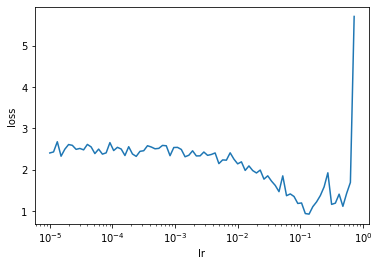

In [ ]:
recorder.plotLRFinder()

In [ ]:
// export
//TODO: when Recorder is a property of Learner don't return it.
extension Learner where Opt.Scalar: PythonConvertible & BinaryFloatingPoint {
    public func lrFind(start: Float = 1e-5, end: Float = 10, numIter: Int = 100) -> Recorder {
        let epochCount = data.train.count/numIter + 1
        let recorder = makeDefaultDelegates()
        delegates.append(makeLRFinder(start: start, end: end, numIter: numIter))
        try! self.fit(epochCount)
        return recorder
    }
}

In [ ]:
let recorder = learner.lrFind()

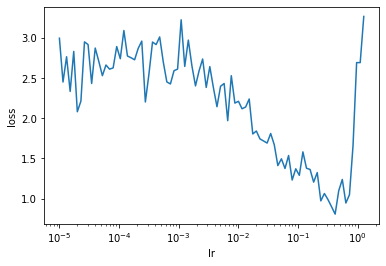

In [ ]:
recorder.plotLRFinder()

## Export

In [ ]:
import NotebookExport
let exporter = NotebookExport(Path.cwd/"05b_early_stopping.ipynb")
print(exporter.export(usingPrefix: "FastaiNotebook_"))

success
